In [1]:
import numpy as np
import pandas as pd
import re
import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

In [2]:
df = pd.read_csv('main_data.csv')  

In [4]:
df['DATE'] = pd.to_datetime(
                          df['DATE'],
                          format='%Y-%m-%d')

In [5]:
df = df.sort_values(by="DATE")

In [37]:
df.loc[df['STOCK'] == "AAIC"]

,Unnamed: 0,DATE,ID,STOCK,SECTOR,TYPE,SCORE,TIME,1MReturn,3MReturn,6MReturn,12MReturn
1886,1886,2004-02-11,SQGF1V-R,AAIC,Finance,MERGED,0.581282,10:01:54.397,0.034188,-0.315176,-0.339732,-0.207120
1887,1887,2004-02-18,SQGF1V-R,AAIC,Finance,MERGED,0.573013,10:01:55.716,0.025974,-0.328256,-0.334790,-0.235541
1888,1888,2004-02-25,SQGF1V-R,AAIC,Finance,MERGED,0.662047,10:01:56.305,-0.029368,-0.296502,-0.305063,-0.244907
1889,1889,2004-03-03,SQGF1V-R,AAIC,Finance,MERGED,0.661088,10:01:57.217,-0.108501,-0.296747,-0.291227,-0.257864
1890,1890,2004-03-10,SQGF1V-R,AAIC,Finance,MERGED,0.673889,10:01:58.760,-0.191662,-0.272496,-0.245068,-0.246662
1891,1891,2004-03-17,SQGF1V-R,AAIC,Finance,MERGED,0.645585,10:01:59.596,-0.202392,-0.243841,-0.225445,-0.324593
1892,1892,2004-03-24,SQGF1V-R,AAIC,Finance,MERGED,0.651256,10:02:00.091,-0.144422,-0.157478,-0.146608,-0.310074
1893,1893,2004-03-31,SQGF1V-R,AAIC,Finance,MERGED,0.515019,10:02:00.823,-0.314561,-0.250408,-0.263910,-0.362419
1894,1894,2004-04-07,SQGF1V-R,AAIC,Finance,MERGED,0.453258,10:02:01.469,-0.274258,-0.224866,-0.225093,-0.373054
1895,1895,2004-04-14,SQGF1V-R,AAIC,Finance,MERGED,0.453731,10:02:02.719,-0.160664,-0.149207,-0.049066,-0.273345


In [7]:
df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

ID        24.496621
SECTOR    24.496621
TYPE      24.496621
SCORE     41.642862
TIME      24.496621
dtype: float64

In [17]:
is_any_null_per_stock = df.groupby('STOCK')['SCORE'].apply(lambda x: x.isnull().any()).to_frame()

In [18]:
is_any_null_per_stock.head()

,SCORE
STOCK,
AA,True
AAIC,False
AAP,False
ABC,True
ABG,True


In [30]:
any_null_per_stock_count = is_any_null_per_stock['SCORE'].value_counts().to_frame()
any_null_per_stock_count.reset_index(inplace=True)
any_null_per_stock_count.columns = ['VALUE', 'COUNT']

In [31]:
any_null_per_stock_count.head()

,VALUE,COUNT
0,True,483
1,False,138


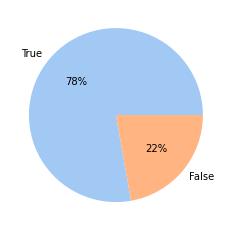

In [34]:
plt.pie(any_null_per_stock_count['COUNT'], labels = any_null_per_stock_count['VALUE'], colors = colors, autopct='%.0f%%')
plt.show()

Almost 80 percent of companies have at least one measing value when it comes to score

In [41]:
is_all_null_per_stock = df.groupby('STOCK')['SCORE'].apply(lambda x: x.isnull().all()).to_frame()
all_null_per_stock_count = is_all_null_per_stock['SCORE'].value_counts().to_frame()
all_null_per_stock_count.reset_index(inplace=True)
all_null_per_stock_count.columns = ['VALUE', 'COUNT']

In [46]:
all_null_per_stock_count

,VALUE,COUNT
0,False,608
1,True,13


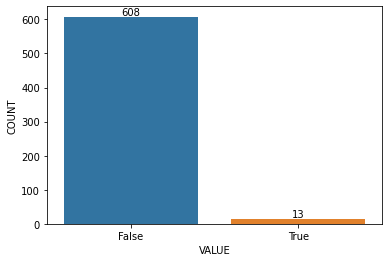

In [50]:
ax = sns.barplot(x='VALUE', y='COUNT', data=all_null_per_stock_count)
ax.bar_label(ax.containers[0])
plt.show()